In [1]:
#allows plots in notebook
%matplotlib inline
#sets notebook figures to high quality svg
%config InlineBackend.figure_format = 'svg'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
#Lets the notebook tranA

#importing ODElib for this demo

import ODElib

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Demo notebook for ODElib - Modeling Infection States (updated 2-12-2021)
This notebook is meant to demonstrate the versatility of ODElib by investigating the performance of different ODEs with a varying number of infection states

In [3]:
def zero_i(y,t,ps):
    mu,phi,beta=ps[0],ps[1],ps[2]
    S,V = y[0],y[1]
    dSdt = mu*S - phi*S*V
    dVdt = beta*phi*S*V - phi*S*V
    return [dSdt,dVdt]

# one infected classes
def one_i(y,t,ps):
    mu,phi,beta,lam=ps[0],ps[1],ps[2],ps[3]
    S,I1,V = y[0],y[1],y[2]
    dSdt = mu*S - phi*S*V
    dI1dt = phi*S*V - lam*I1
    dVdt = beta*lam*I1 - phi*S*V
    return np.array([dSdt,dI1dt,dVdt])


In [4]:
def plot_histogram(series,logspace=True, name=None):
    if logspace:
        axessubplot = series.hist(bins=np.logspace(np.log10(series.min()),
                                                   np.log10(series.max()), 50))
        axessubplot.figure.gca().set_xscale("log")
    else:
        axessubplot = series.hist(bins=np.linspace(series.min(),series.max(), 50))
    if series.name or name:
        if name:
            axessubplot.set_title(name)
        else:
            axessubplot.set_title(series.name)
    return(axessubplot)

In [5]:
df = pd.read_csv("testdat.csv")
df=df.replace({'virus':'V','host':'H'})
df=df.rename({'uncertainty':'sigma'},axis=1)
df['log_sigma'] = ODElib.Statistics.stats.predict_logsigma(df['sigma'],df['abundance'])
df

,organism,time,abundance,sigma,log_sigma
0,V,0.0,10981000,656690.00,0.059749
1,V,0.2,12959000,2987300.00,0.227542
2,V,0.3,13273000,3480600.00,0.257884
3,V,0.5,17914000,3981250.00,0.219569
4,V,0.7,15899000,4815700.00,0.296271
5,V,0.9,13881000,3985500.00,0.281452
6,V,0.9,15545000,3491900.00,0.221873
7,V,1.0,14527000,5474350.00,0.364401
8,V,1.2,12516000,6314200.00,0.476178
9,V,1.3,32464000,22926000.00,0.636088


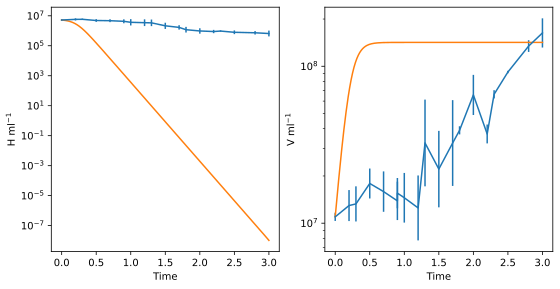

In [6]:
mu_p=ODElib.parameter(9.240999e-08,scipy.stats.lognorm,{'s':3,'scale':1e-8})
phi_p=ODElib.parameter(8.547952e-08,scipy.stats.lognorm,{'s':3,'scale':1e-8})
beta_p=ODElib.parameter(26,scipy.stats.lognorm,{'s':1,'scale':25})


zeroI=ODElib.ModelFramework(ODE=zero_i,
                          parameter_names=['mu','phi','beta'],
                          state_names = ['H','V'],
                          dataframe=df,
                          mu = mu_p,
                          phi = phi_p,
                          beta = beta_p,
                          t_steps=288
                         )
f,ax = zeroI.plot()

# Poor fits
We see we have very poor fits. To find better values, we can launch MCMC.

In [7]:
posterior = zeroI.MCMC(chain_inits=32,cpu_cores=8,fitsurvey_samples=10000)

Starting 8 processes with 8 cores	[DONE]
Starting 32 processes with 8 cores	[DONE]

Fitting Report
parameter: mu
	median = 3.714e-09, Standard deviation = 4.034e-06
parameter: phi
	median = 1.377e-08, Standard deviation = 4.825e-10
parameter: beta
	median = 1.914e+01, Standard deviation = 4.115e-01

Median parameter fit stats:
	Chi = 9.138e+04
	Adjusted R-squared = -4.764e+00
	AIC = inf


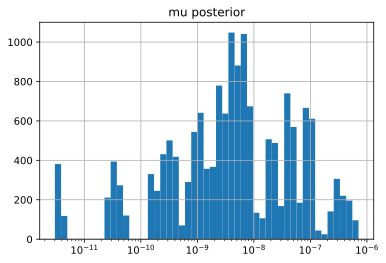

In [8]:
muposterior=plot_histogram(posterior['mu'],name='mu posterior')

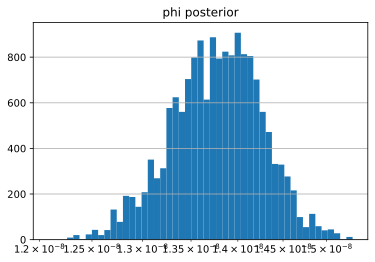

In [9]:
phiposterior=plot_histogram(posterior['phi'],name='phi posterior')

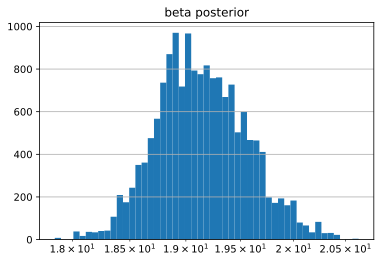

In [10]:
betaposterior=plot_histogram(posterior['beta'],name='beta posterior')

(<Figure size 648x324 with 2 Axes>,
 array([<AxesSubplot:xlabel='Time', ylabel='H ml$^{-1}$'>,
        <AxesSubplot:xlabel='Time', ylabel='V ml$^{-1}$'>], dtype=object))

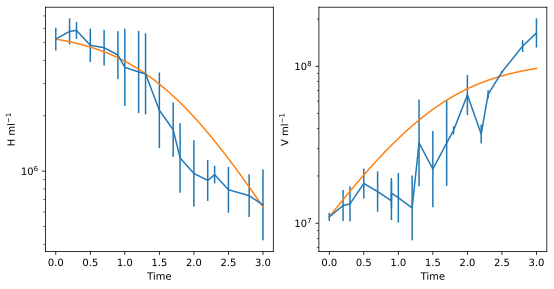

In [11]:
#grabbing a parameter set from the posterior to show fits are much better
zeroI.set_parameters(**posterior.iloc[-1][zeroI.get_pnames()].to_dict())
zeroI.plot()

# 1 infection state

(<Figure size 648x324 with 2 Axes>,
 array([<AxesSubplot:xlabel='Time', ylabel='H ml$^{-1}$'>,
        <AxesSubplot:xlabel='Time', ylabel='V ml$^{-1}$'>], dtype=object))

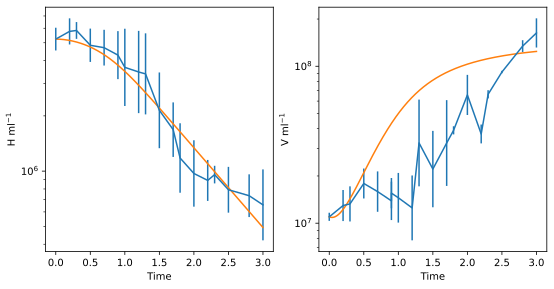

In [12]:
mu_p=ODElib.parameter(9.240999e-08,scipy.stats.lognorm,{'s':3,'scale':1e-8})
phi_p=ODElib.parameter(8.547952e-08,scipy.stats.lognorm,{'s':3,'scale':1e-8})
beta_p=ODElib.parameter(25,scipy.stats.lognorm,{'s':1,'scale':25})
lam_p=ODElib.parameter(1,scipy.stats.lognorm,{'s':1,'scale':.01})

oneI=ODElib.ModelFramework(ODE=one_i,
                          parameter_names=['mu','phi','beta','lam'],
                          state_names = ['S','I1','V'],
                          dataframe=df,
                          mu = mu_p,
                          phi = phi_p,
                          beta = beta_p,
                          lam=lam_p, 
                          t_steps=1000,
                          state_summations={'H':['S','I1']},
                          S=5236900
                         )
oneI.plot()

In [13]:
#changed sd_fitdistance to cast wider net
posterior_onei = oneI.MCMC(chain_inits=8,cpu_cores=8,fitsurvey_samples=10000,sd_fitdistance=4.0)
posterior_onei

Starting 8 processes with 8 cores	[DONE]
Starting 8 processes with 8 cores	[DONE]

Fitting Report
parameter: mu
	median = 5.123e-09, Standard deviation = 1.293e-06
parameter: phi
	median = 3.224e-08, Standard deviation = 7.992e-09
parameter: beta
	median = 1.996e+01, Standard deviation = 2.926e+00
parameter: lam
	median = 1.580e+00, Standard deviation = 5.972e-01

Median parameter fit stats:
	Chi = 6.221e+02
	Adjusted R-squared = 7.713e-02
	AIC = 1.252e+03


,mu,phi,beta,lam,chi,iteration,acceptance_ratio,chain#
0,1.754986e-09,3.979998e-08,19.032522,1.340818,187.351264,501,0.233533,0
1,1.689082e-09,3.744327e-08,19.542267,1.356044,185.574957,502,0.235060,0
2,1.724117e-09,3.835464e-08,18.931139,1.415118,185.451262,503,0.236581,0
3,1.724117e-09,3.835464e-08,18.931139,1.415118,185.451262,504,0.236111,0
4,1.724117e-09,3.835464e-08,18.931139,1.415118,185.451262,505,0.235644,0
...,...,...,...,...,...,...,...,...
3987,1.079632e-10,2.727244e-08,18.755086,2.274841,180.654372,995,0.184925,7
3988,1.115015e-10,2.877112e-08,18.412347,2.148900,181.036599,996,0.185743,7
3989,1.115015e-10,2.877112e-08,18.412347,2.148900,181.036599,997,0.185557,7
3990,1.115015e-10,2.877112e-08,18.412347,2.148900,181.036599,998,0.185371,7


(<Figure size 648x324 with 2 Axes>,
 array([<AxesSubplot:xlabel='Time', ylabel='H ml$^{-1}$'>,
        <AxesSubplot:xlabel='Time', ylabel='V ml$^{-1}$'>], dtype=object))

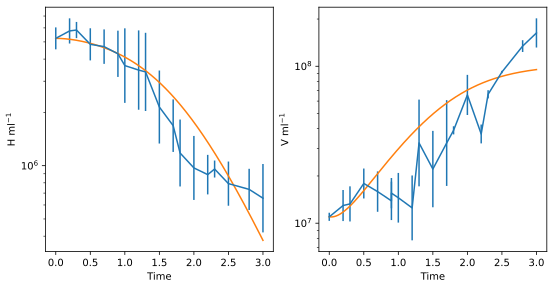

In [14]:
oneI.set_parameters(**posterior_onei.iloc[-1][oneI.get_pnames()].to_dict())
oneI.plot()

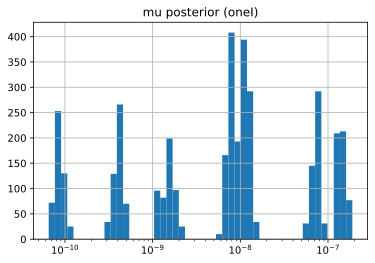

In [15]:
muposterior=plot_histogram(posterior_onei['mu'],name='mu posterior (oneI)')

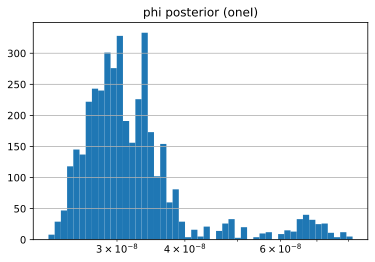

In [16]:
phiposterior=plot_histogram(posterior_onei['phi'],name='phi posterior (oneI)')

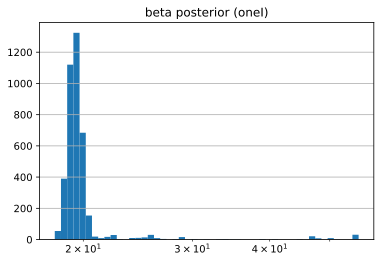

In [17]:
betaposterior=plot_histogram(posterior_onei['beta'],name='beta posterior (oneI)')

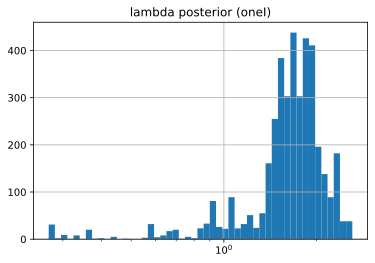

In [18]:
lamposterior=plot_histogram(posterior_onei['lam'],name='lambda posterior (oneI)')